In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [125]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [126]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [127]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

independent_variables = [var for var in independent_variables if var not in columns_to_predict]
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
if "Hour_2" in independent_variables:
    independent_variables.remove("Hour_2")
if "Hour_3" in independent_variables:
    independent_variables.remove("Hour_3")
    

for i in independent_variables:
    print(f"{i}, corr: {'%.3f' % abs(train[i].corr(train[columns_to_predict[0]]))}")

Hour_1, corr: 0.432
Occupant Count (people)_3, corr: 0.458
12h Outdoor Drybulb Temperature (C), corr: 0.605
24h Outdoor Drybulb Temperature (C), corr: 0.401
12h Outdoor Relative Humidity (%), corr: 0.525
6h Direct Solar Radiation (W/m2), corr: 0.532
12h Direct Solar Radiation (W/m2), corr: 0.415


Prepare the data

In [128]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 7)
(96, 7)
(96, 7)


In [129]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [130]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 7), Y_train = (505, 24, 2)
X_val = (25, 48, 7), Y_val = (25, 24, 2)
X_test = (25, 48, 7), Y_test = (25, 24, 2)


In [131]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models
import time

tscv = TimeSeriesSplit(n_splits = 4, test_size=NUM_OF_TIMESTEPS_OUTPUT) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 4) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Permute layer
permute_layer = layers.Permute((2, 1))(input_layer)

# Flatten layer
flatten_layer = layers.Flatten()(permute_layer)

# Dense layers for variable 1
dense1 = layers.Dense(192, activation='leaky_relu')(flatten_layer)
dense2 = layers.Dense(96, activation='leaky_relu')(dense1)
dense3 = layers.Dense(48, activation='leaky_relu')(dense2)
output_variable1 = layers.Dense(24, name='output_variable1')(dense3)

# Dense layers for variable 2
dense4 = layers.Dense(192, activation='leaky_relu')(flatten_layer)
dense5 = layers.Dense(96, activation='leaky_relu')(dense4)
dense6 = layers.Dense(48, activation='leaky_relu')(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    

start = time.time()
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=100, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])

end = time.time()

print(f"Training time = {end - start} seconds")

Epoch 1/100
13/13 [==============================] - 3s 37ms/step - loss: 0.2839 - output_variable1_loss: 0.1564 - output_variable2_loss: 0.1275 - val_loss: 0.2546 - val_output_variable1_loss: 0.2057 - val_output_variable2_loss: 0.0489
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0919 - output_variable1_loss: 0.0442 - output_variable2_loss: 0.0478 - val_loss: 0.1973 - val_output_variable1_loss: 0.1681 - val_output_variable2_loss: 0.0292
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0569 - output_variable1_loss: 0.0334 - output_variable2_loss: 0.0235 - val_loss: 0.1536 - val_output_variable1_loss: 0.1318 - val_output_variable2_loss: 0.0217
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0427 - output_variable1_loss: 0.0280 - output_variable2_loss: 0.0147 - val_loss: 0.1179 - val_output_variable1_loss: 0.1015 - val_output_variable2_loss: 0.0165
Epoch 5/100
13/13 [==============================] - 0s 8m

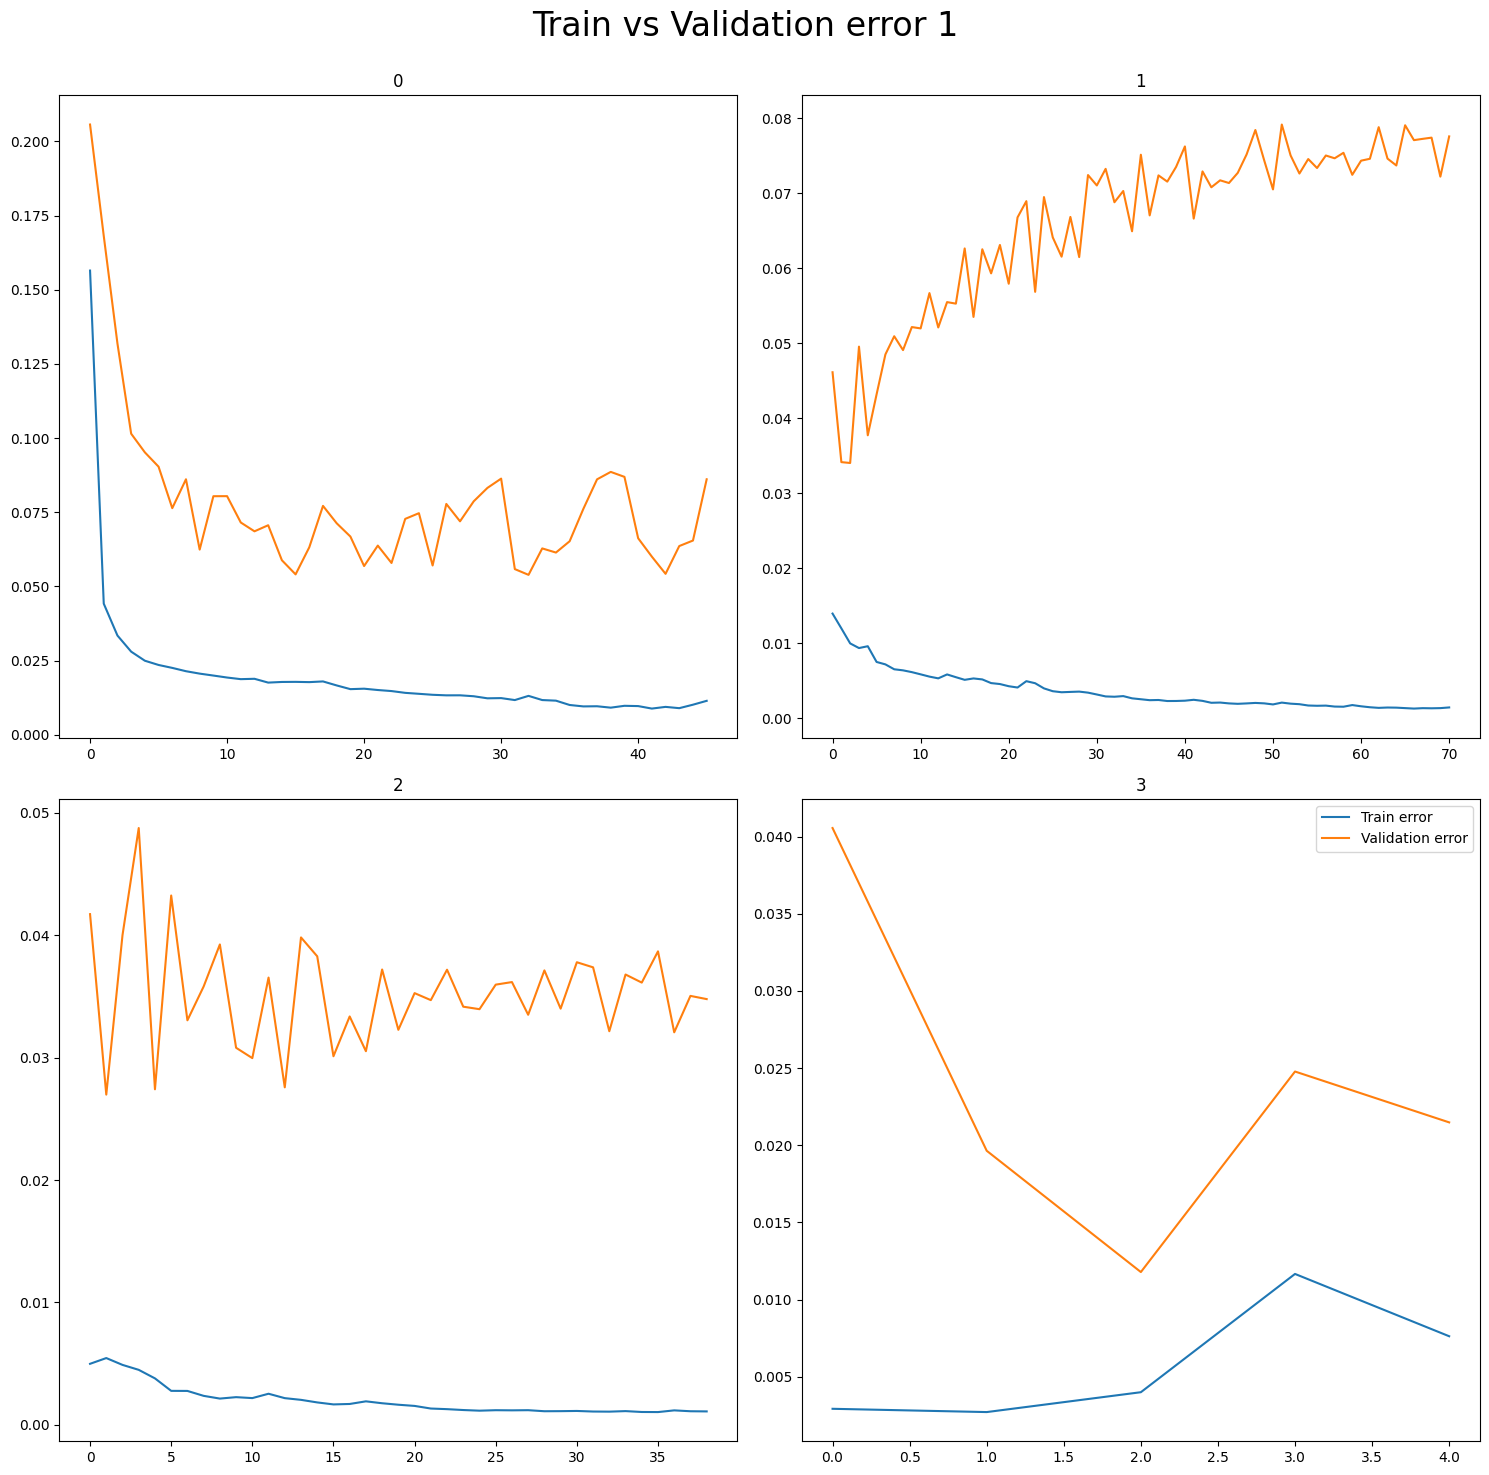

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

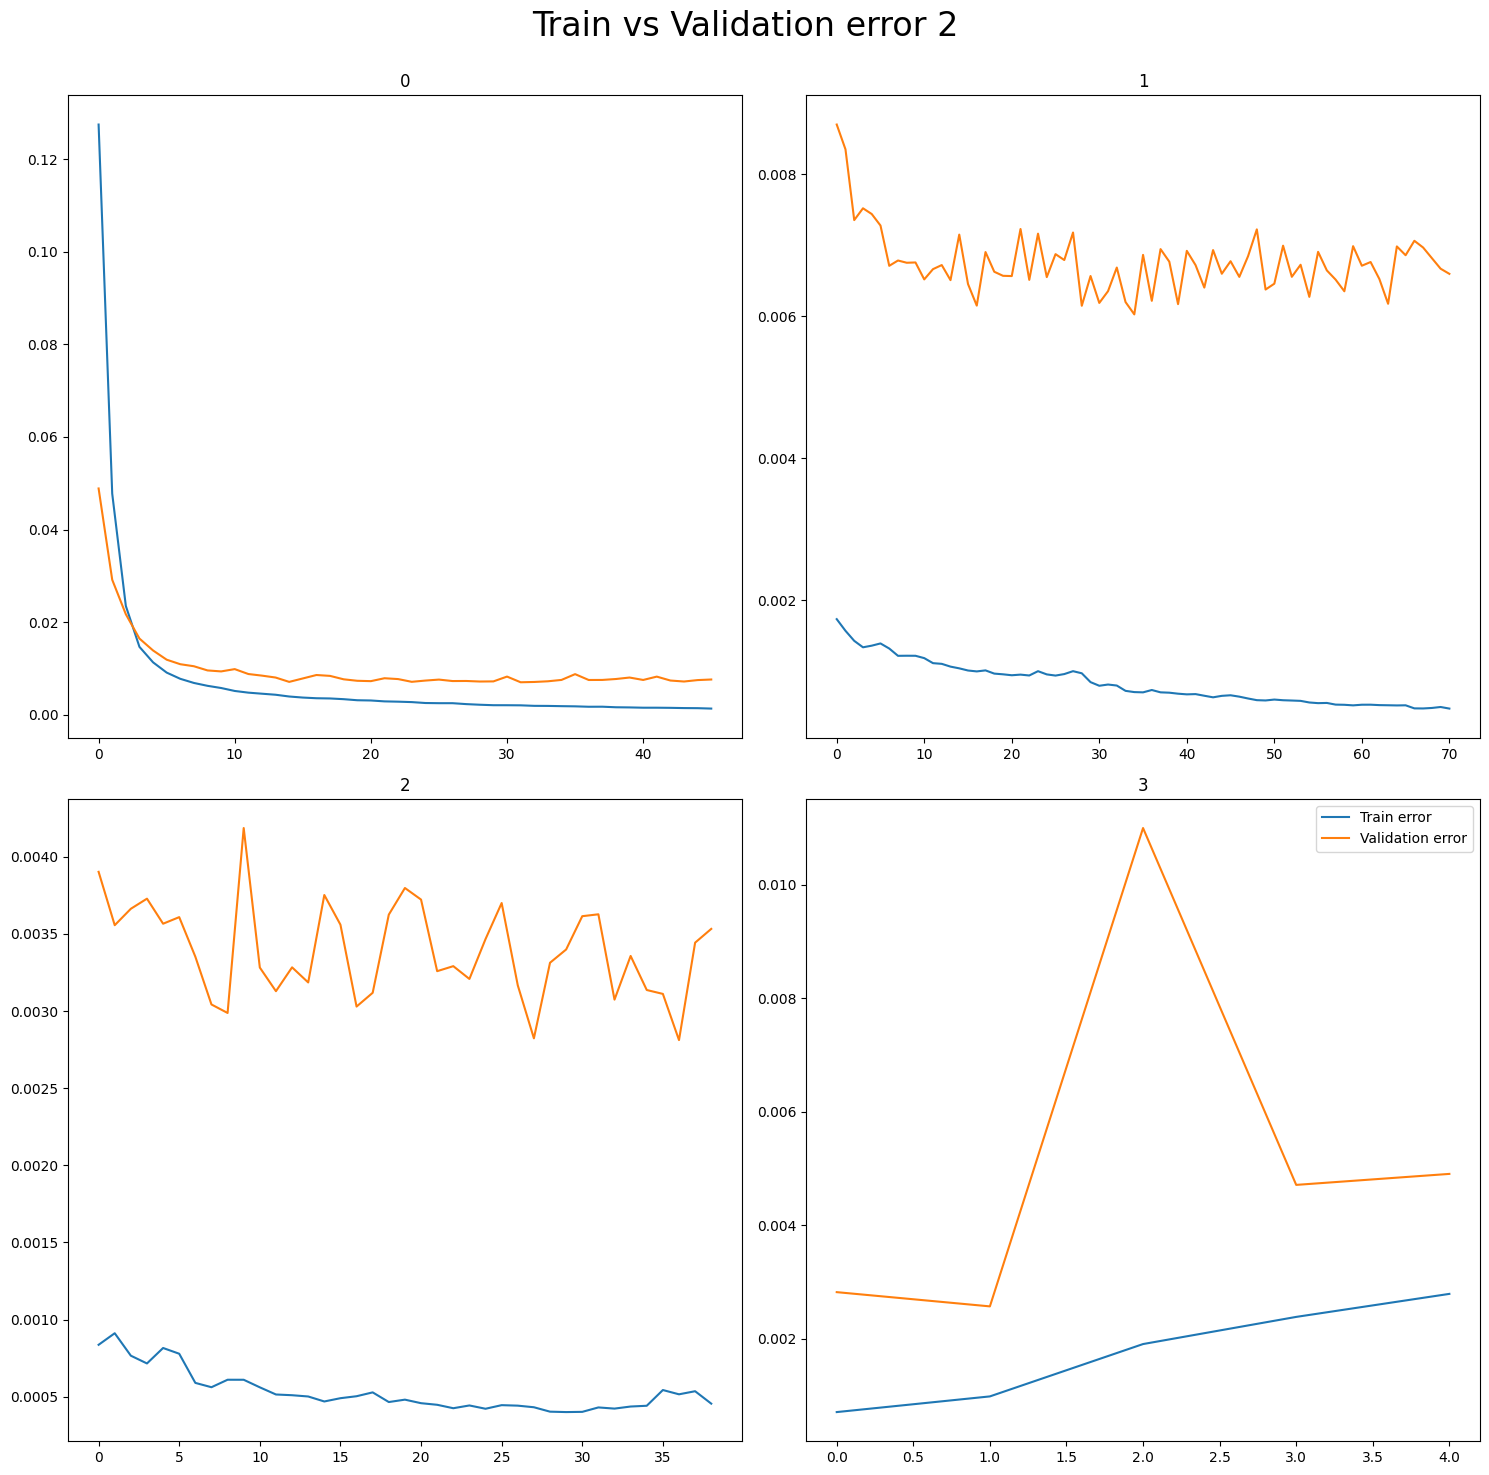

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

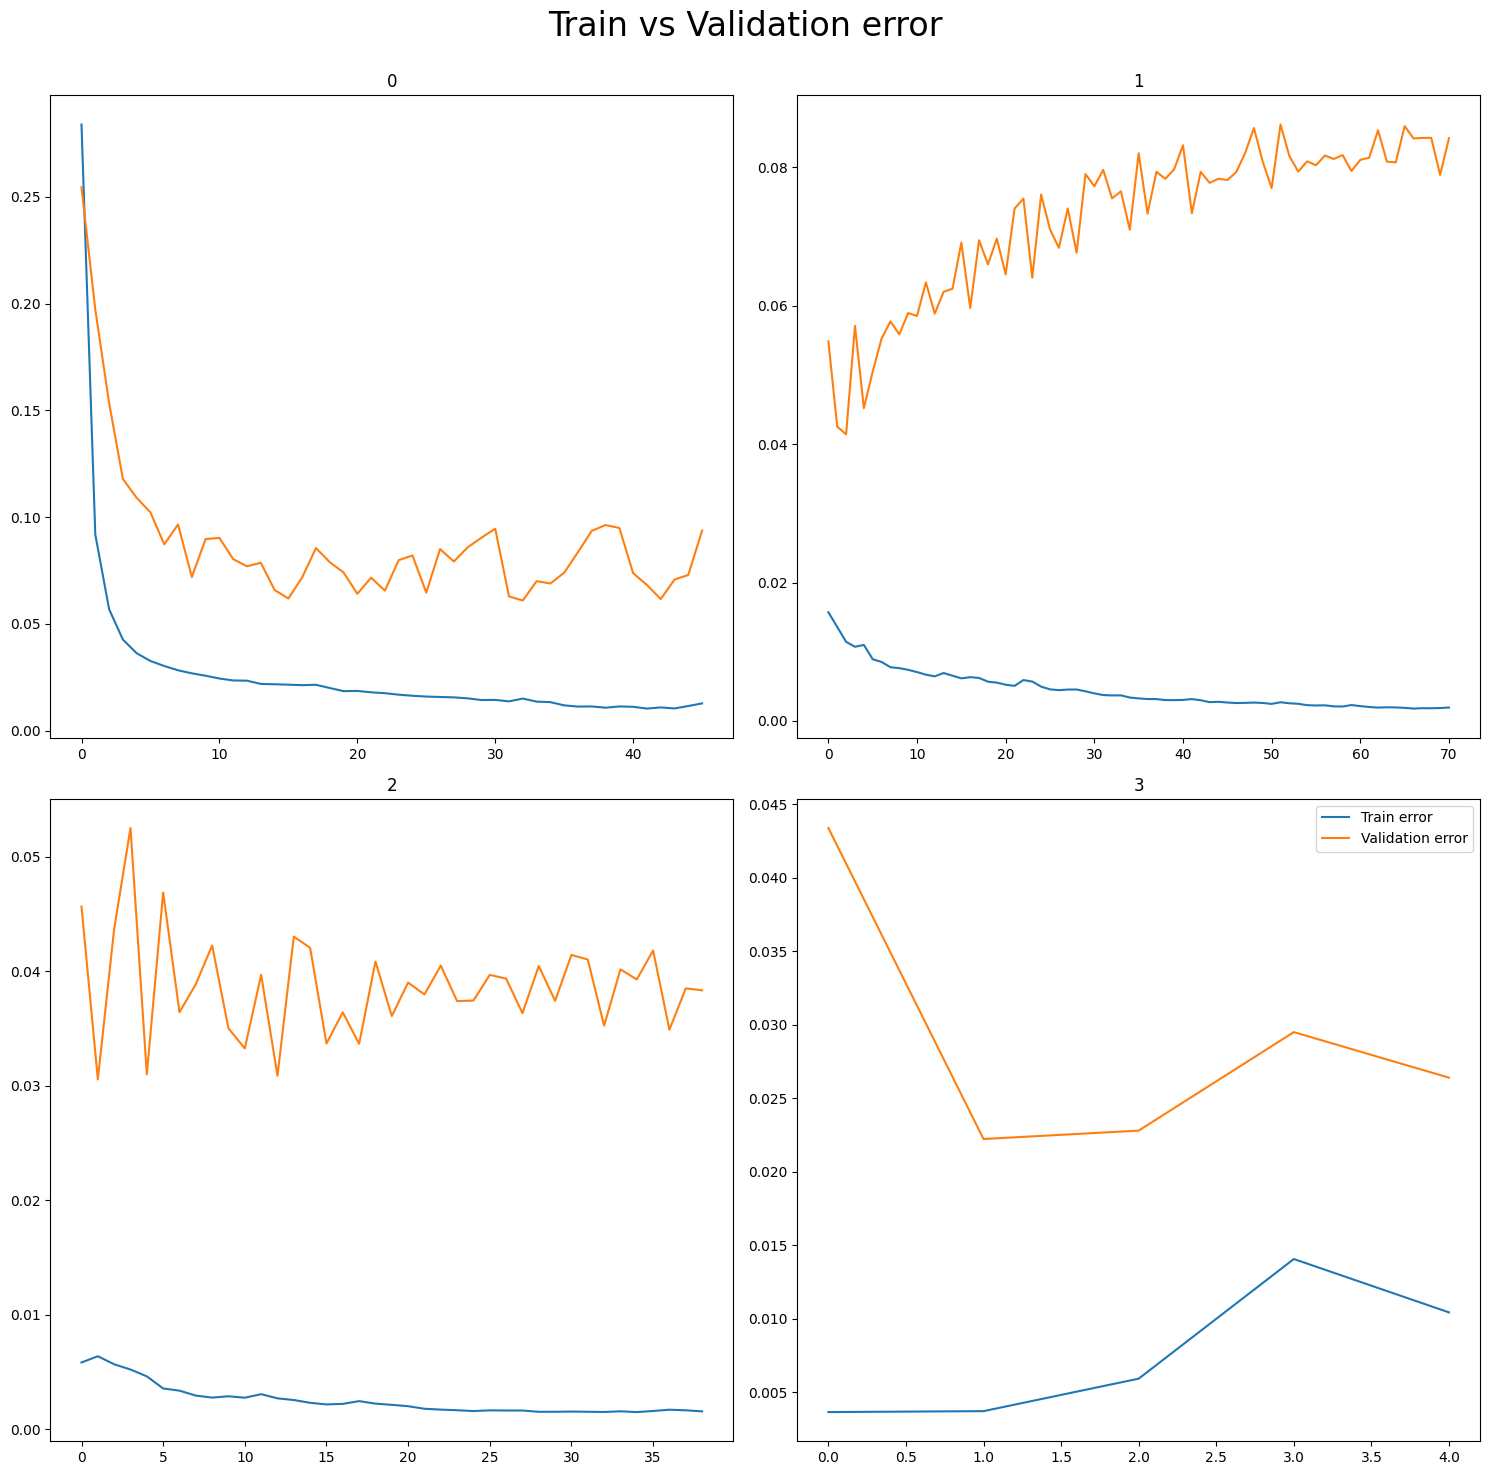

In [134]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [135]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 35ms/step


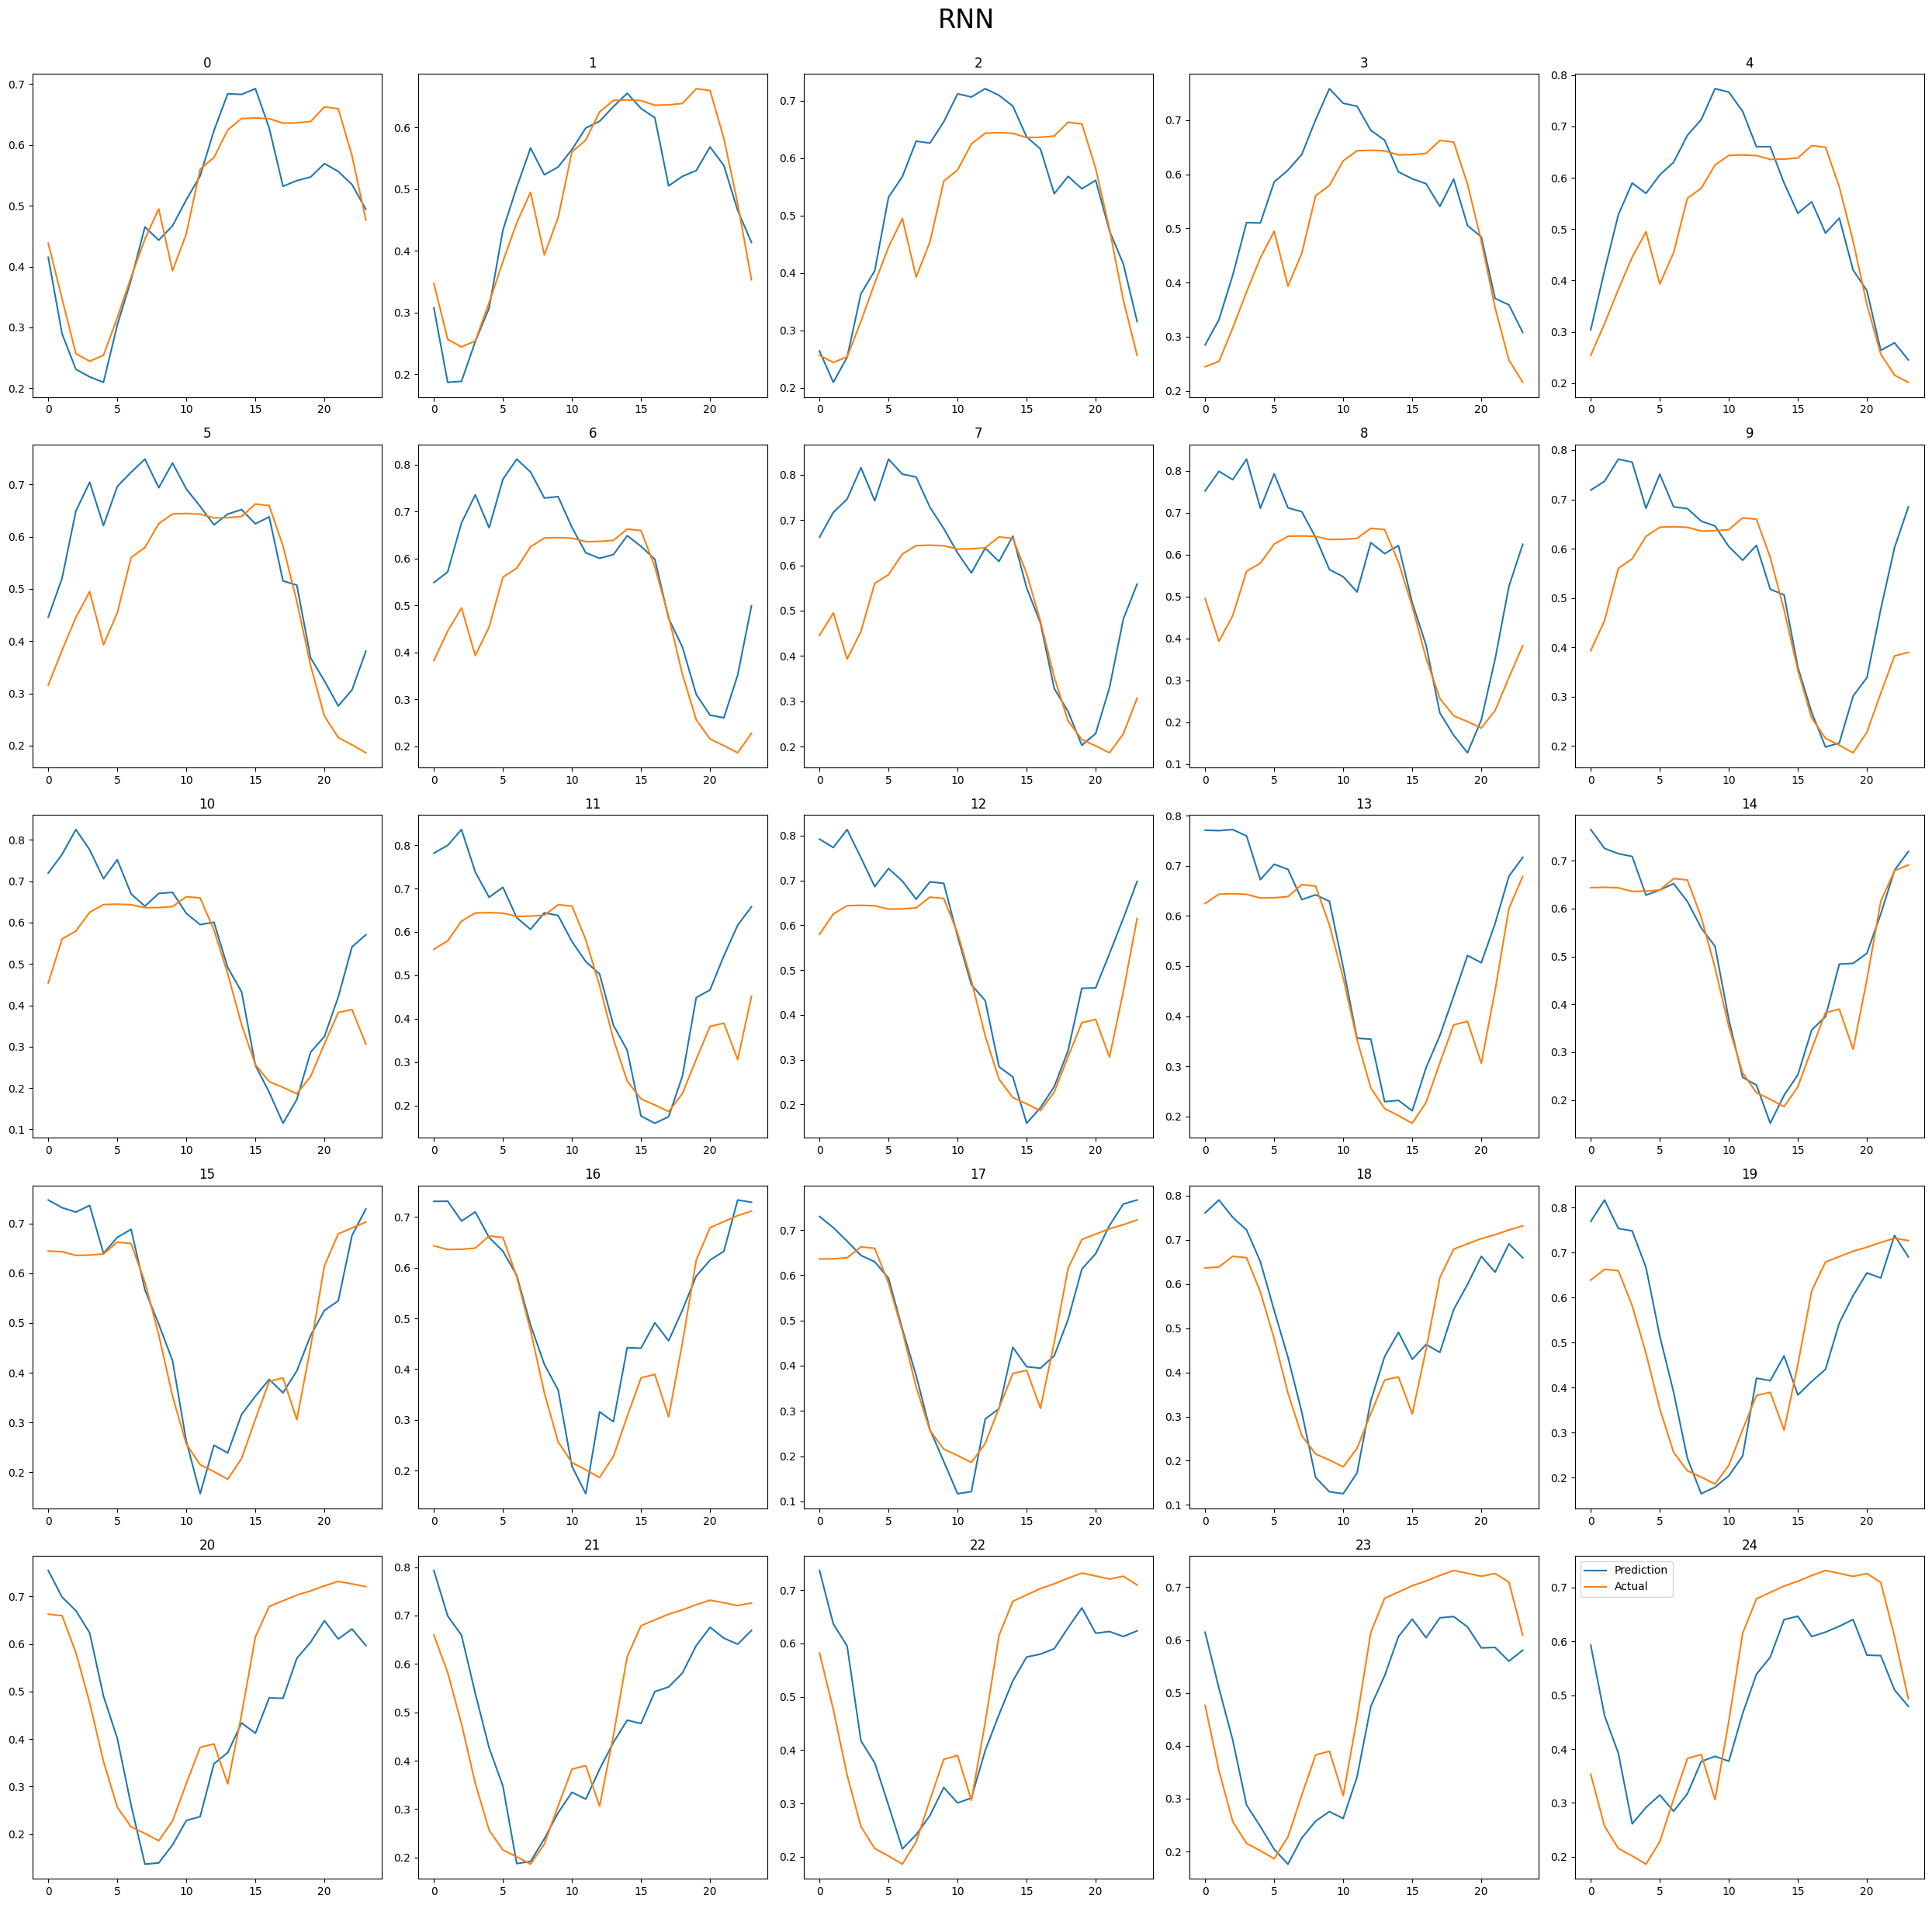

In [136]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

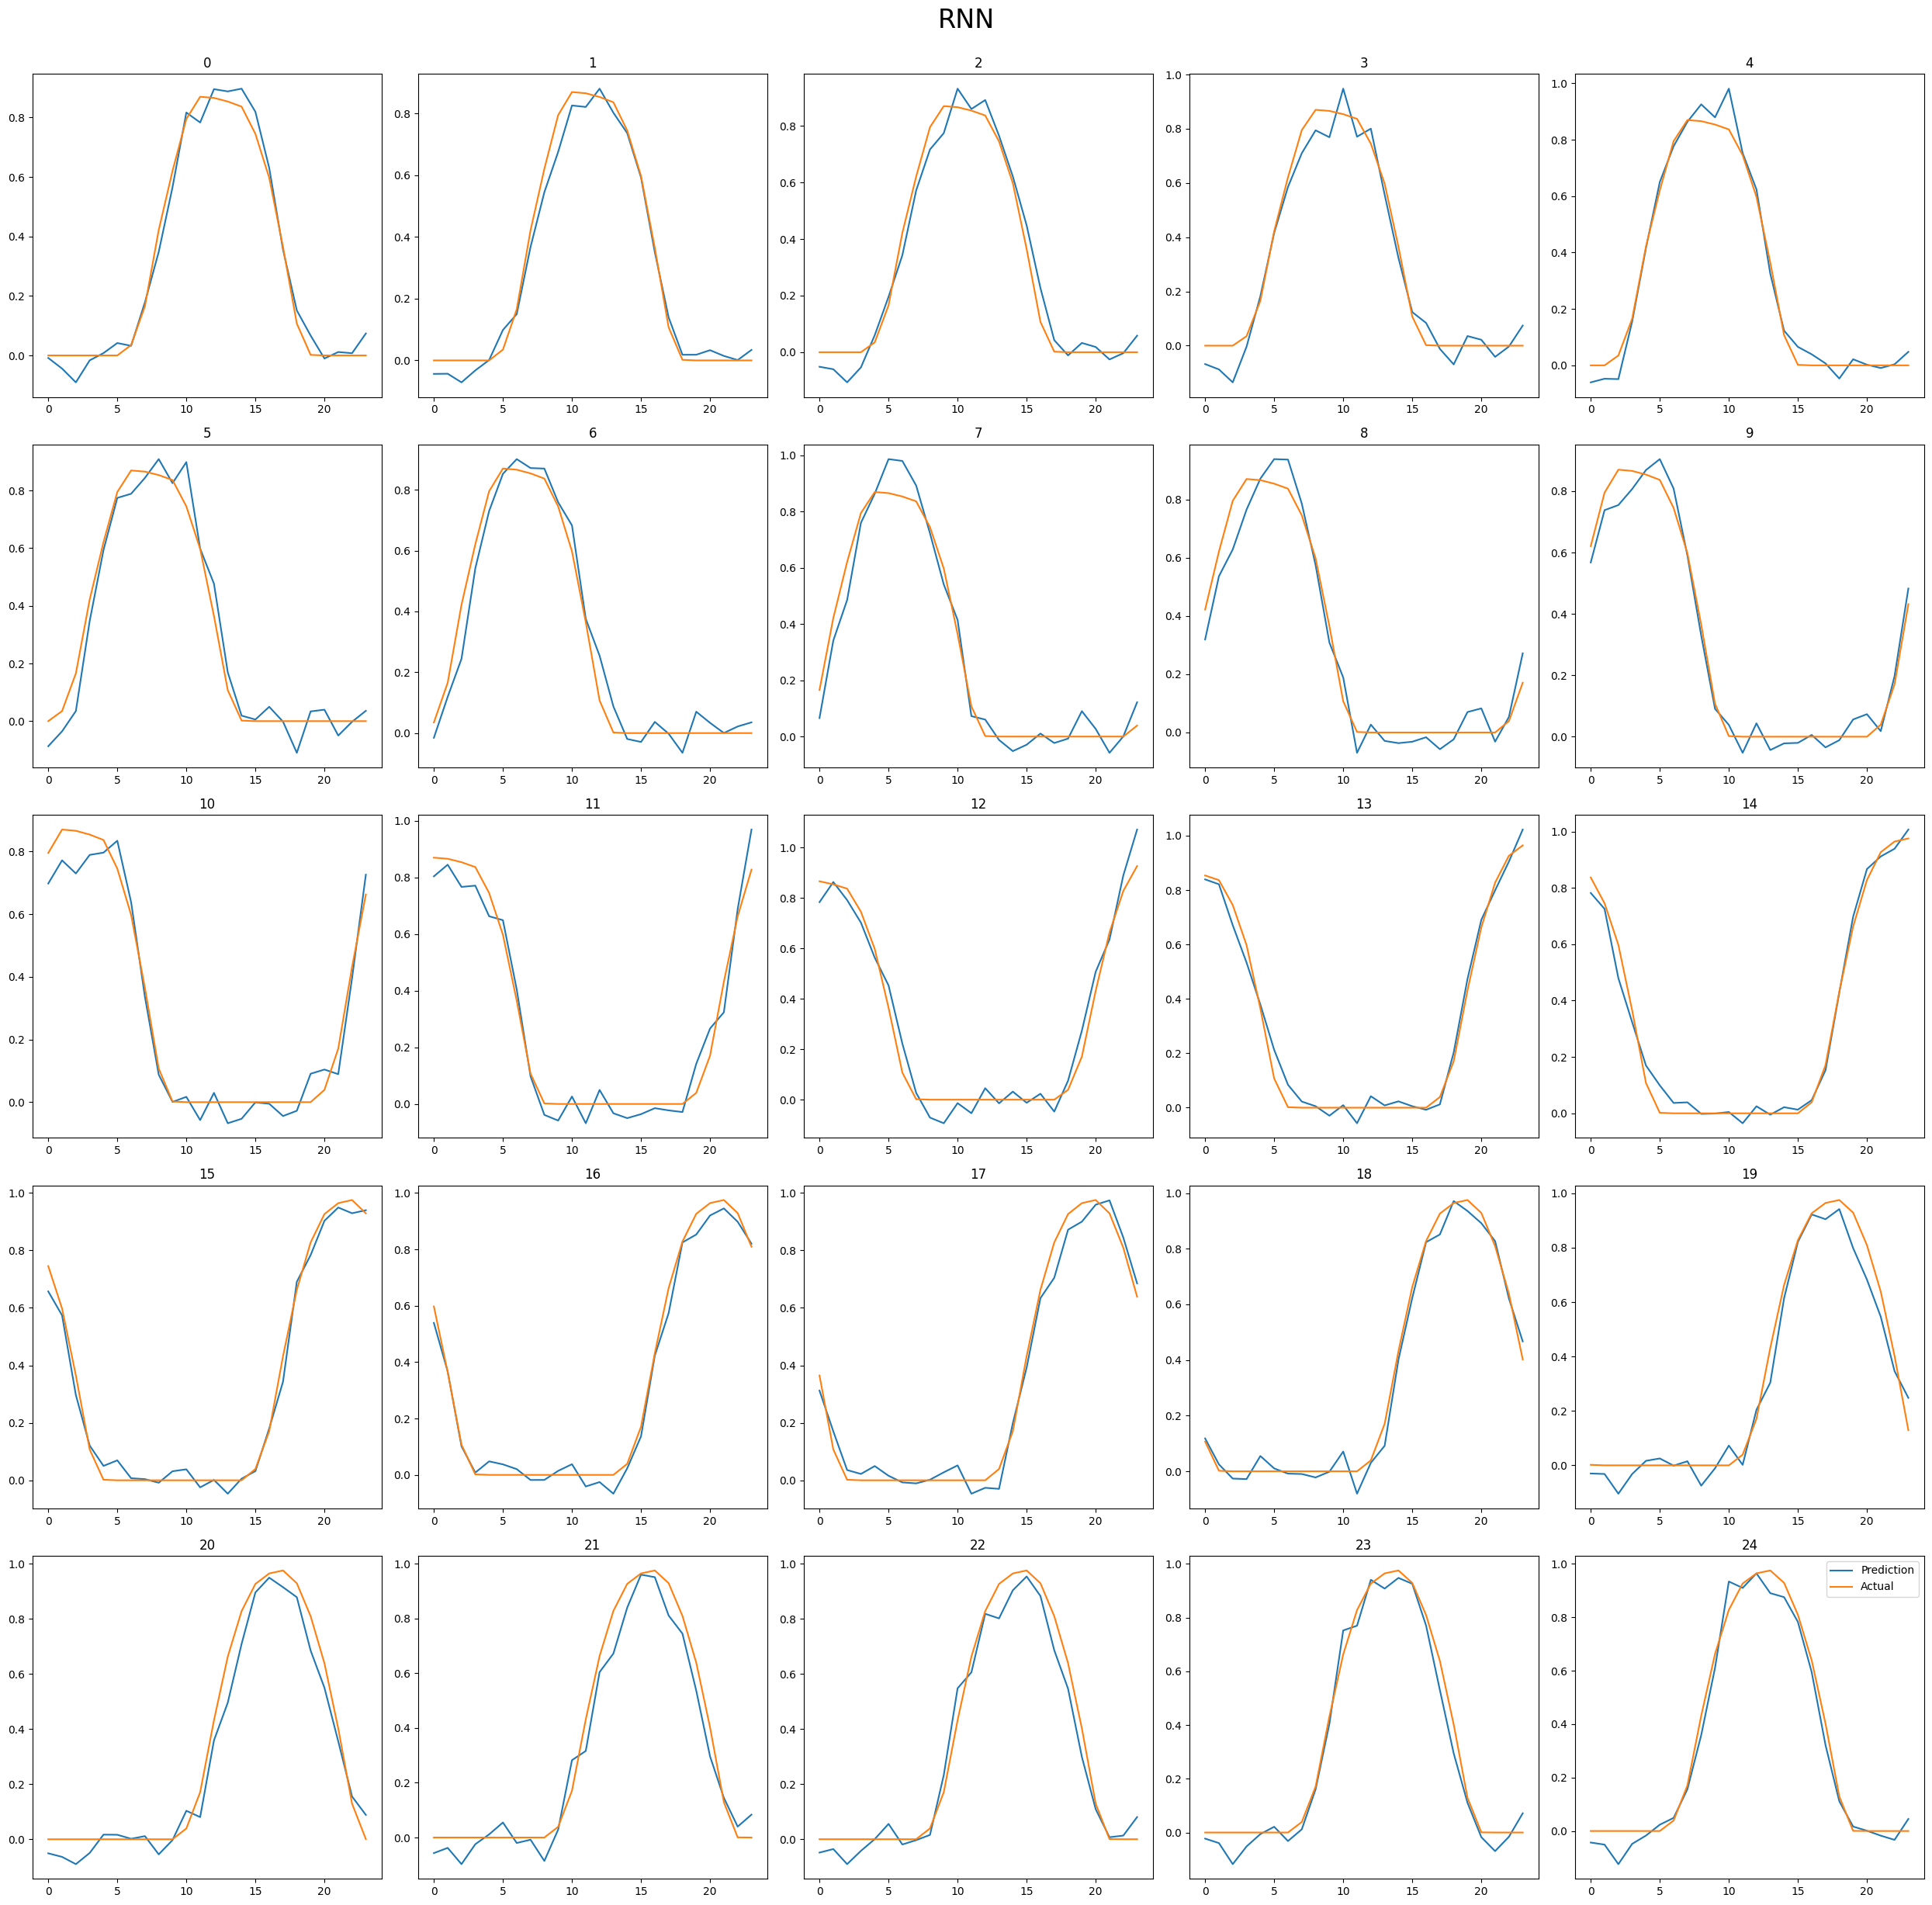

In [137]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [138]:
rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.10470286454833073
RMSE for Avg solar generation = 0.056312823181035


In [139]:
# Evaluate the model on the test data
predictions_1_test = []
predictions_2_test = []
#print(len(eval_target_variables))

for i in range(len(Y_test)):
    current_batch = X_test[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1_test.append(curr_pred1)
    predictions_2_test.append(curr_pred2)

1/1 [==============================] - 0s 31ms/step


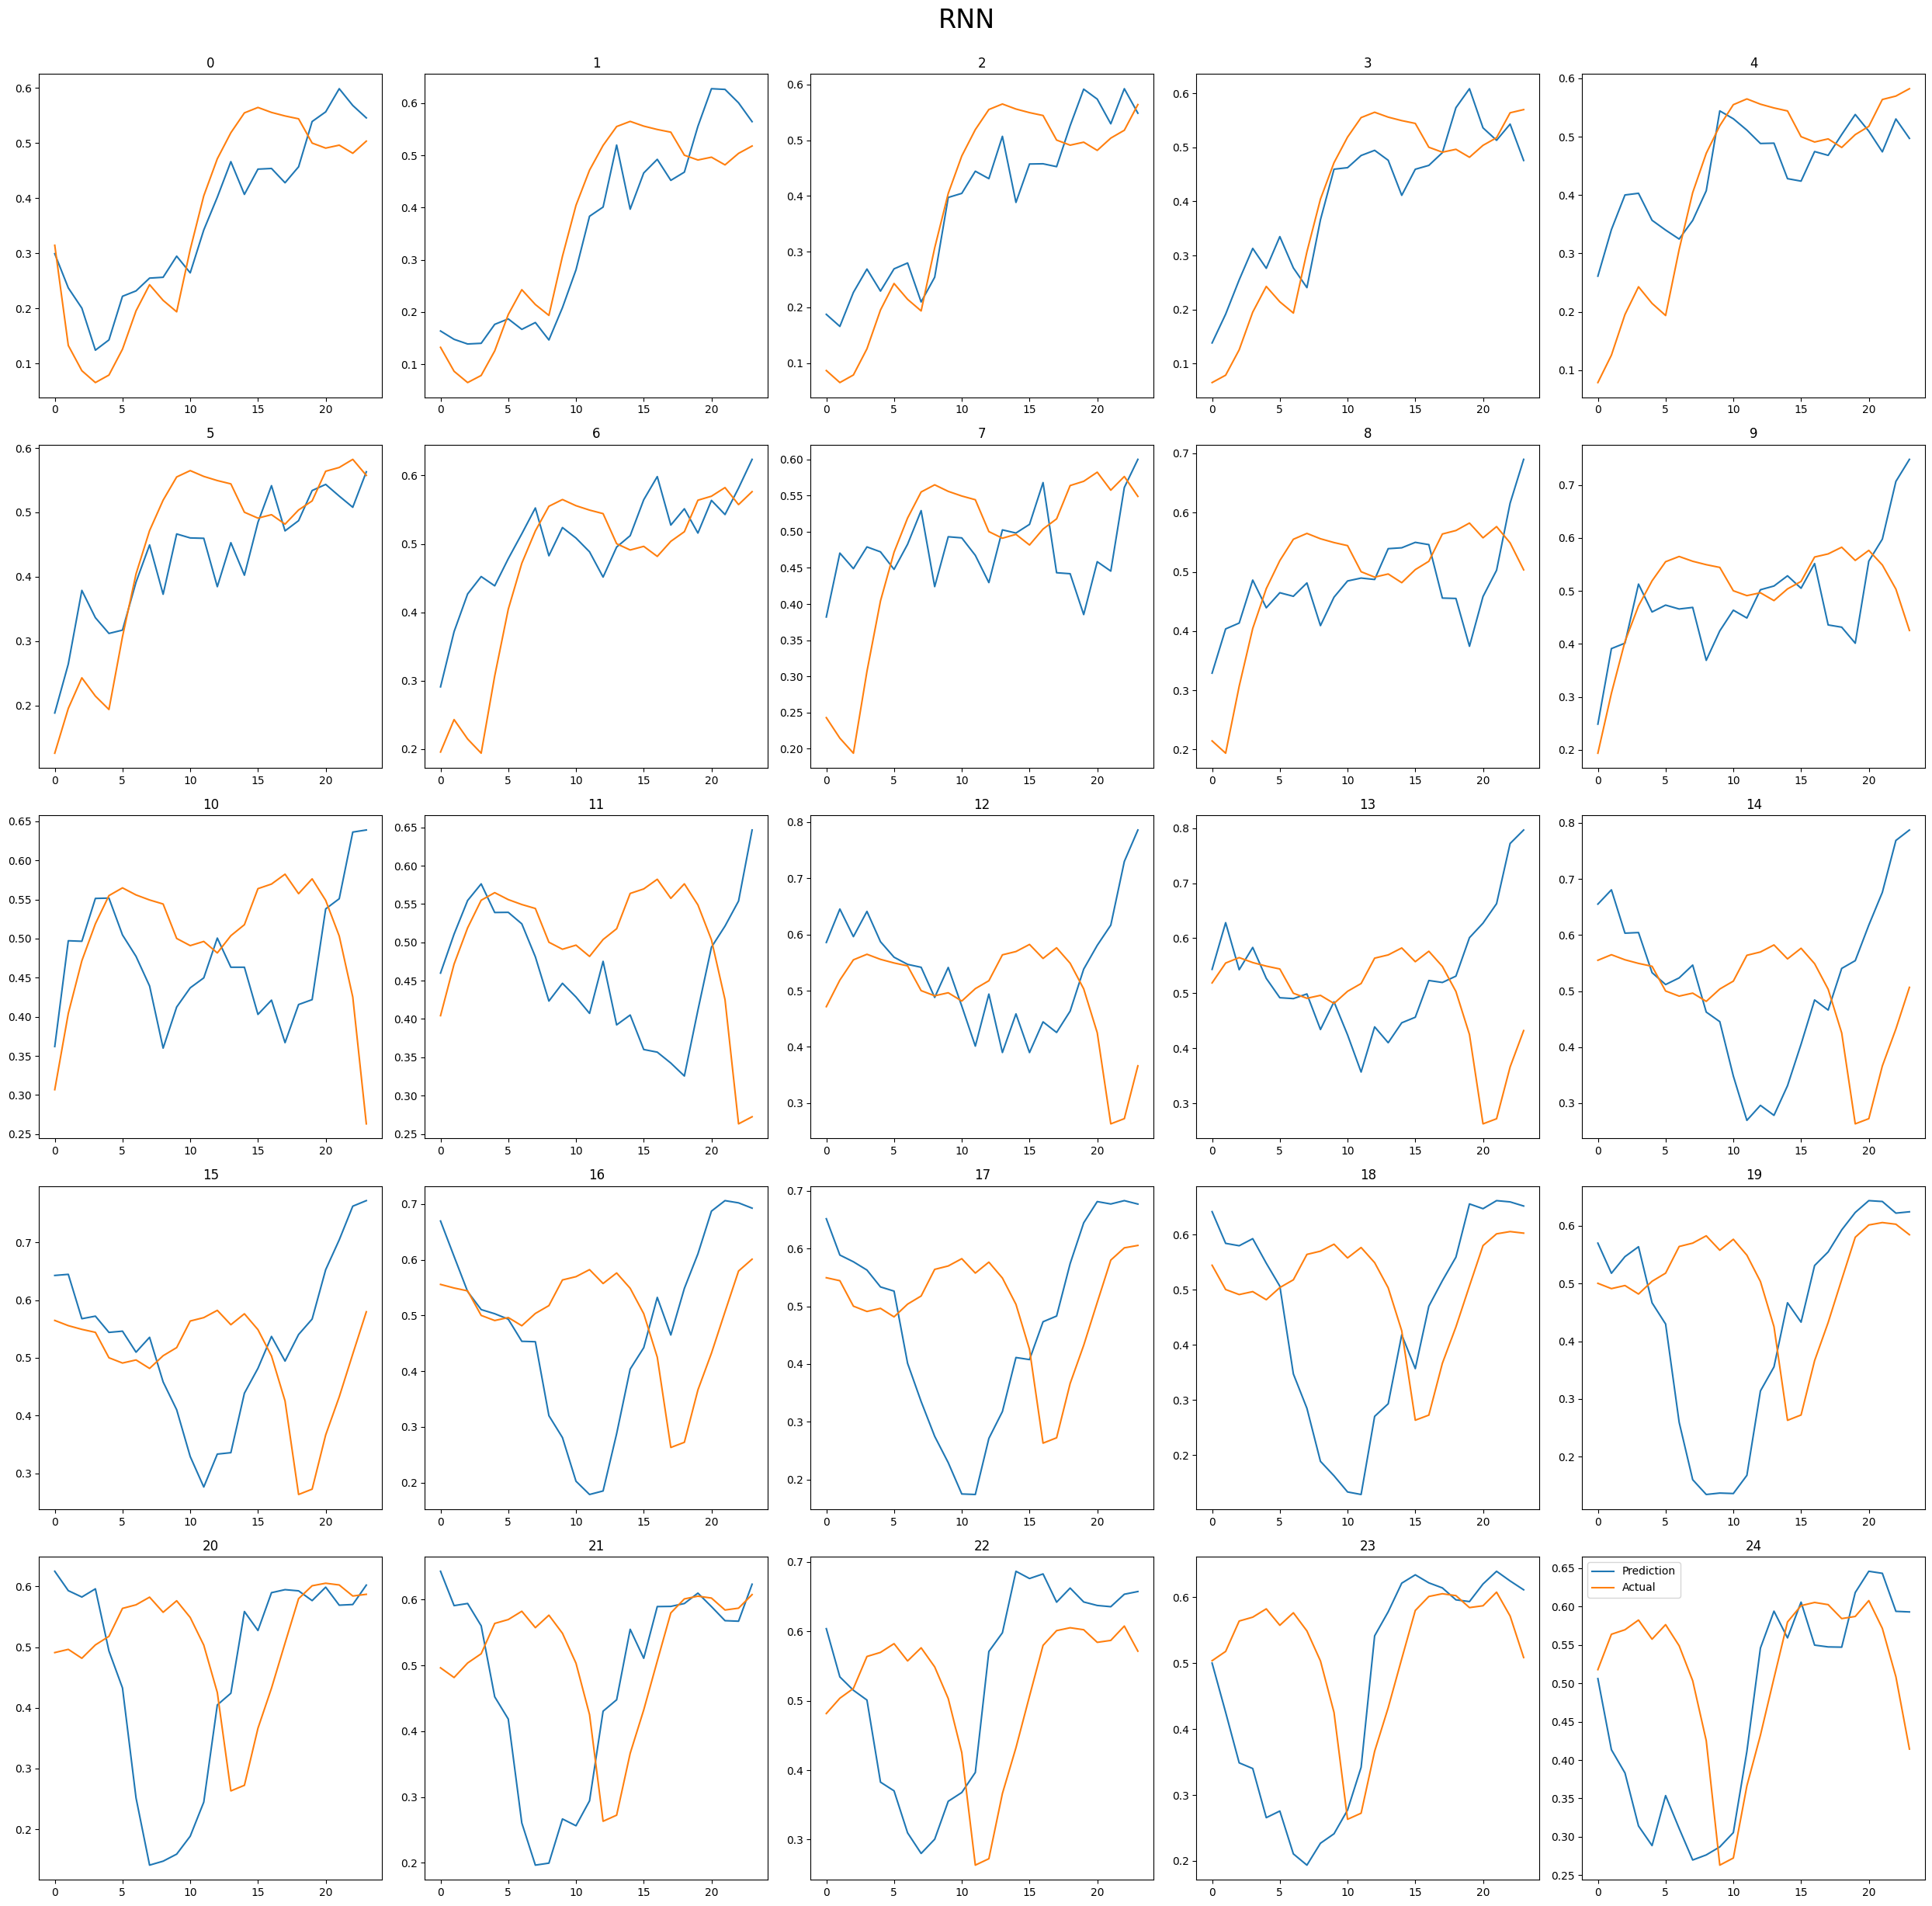

In [140]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

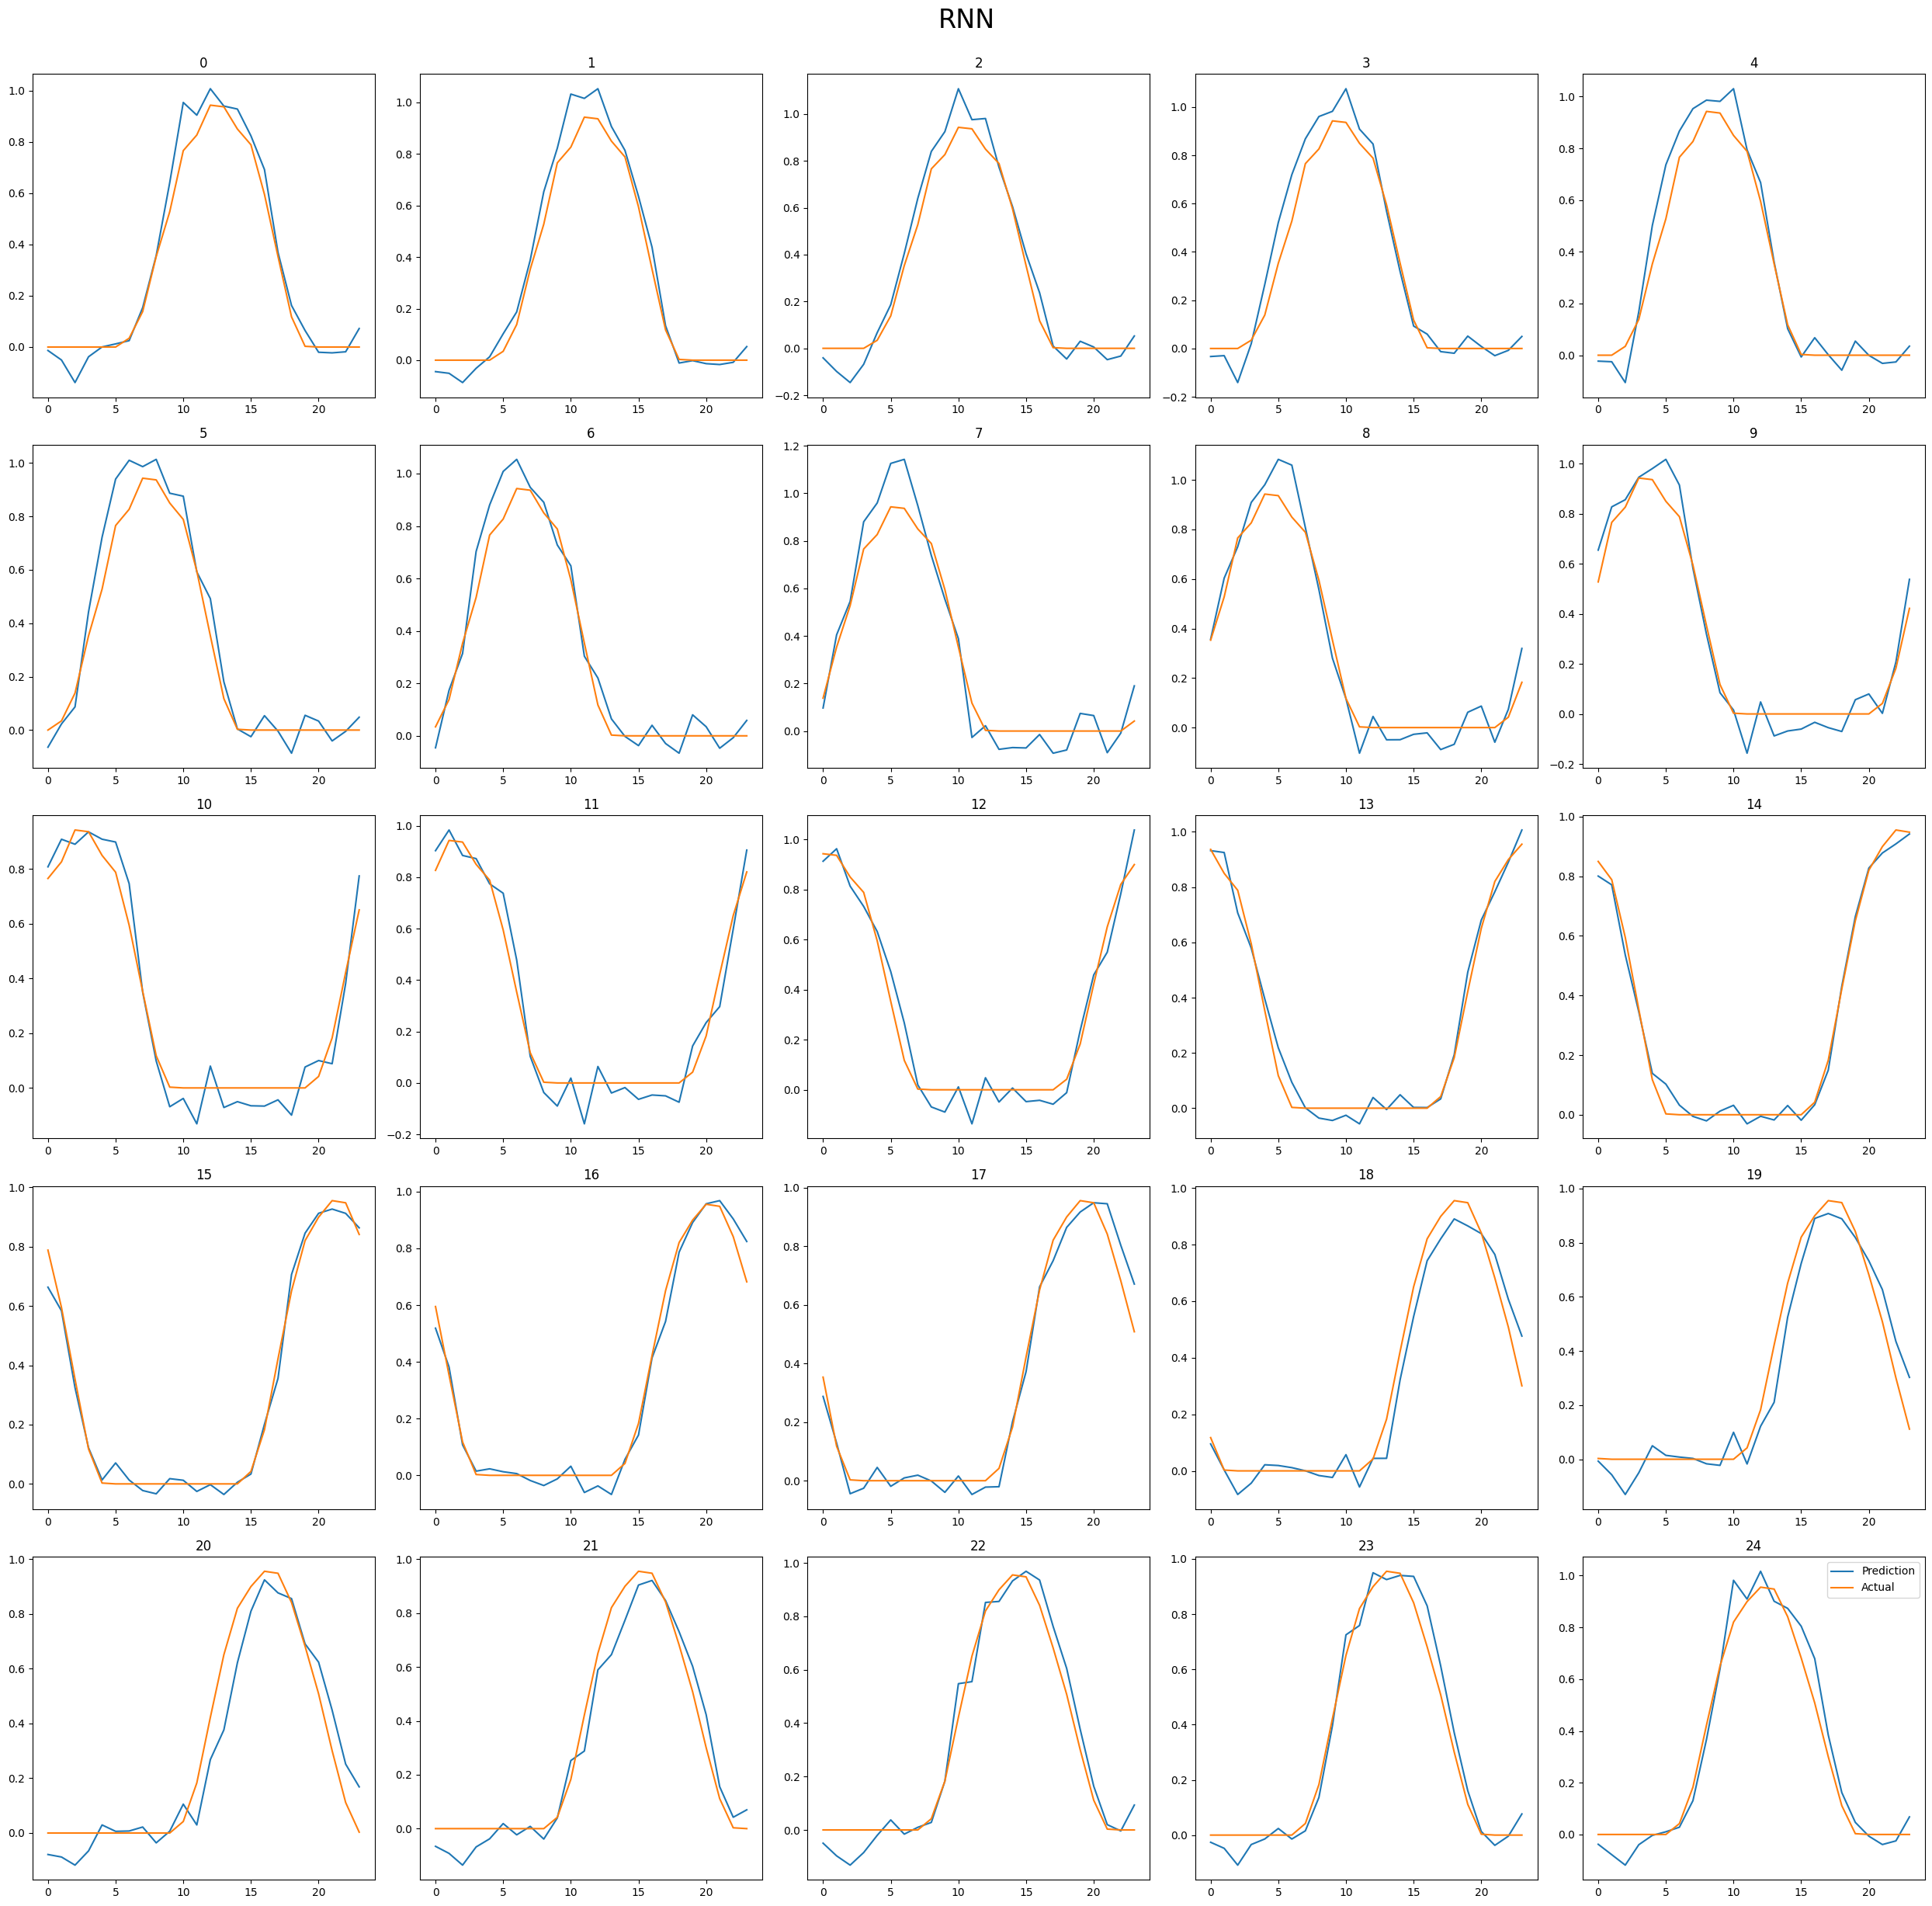

In [141]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [142]:
rmse = 0
for i in range(len(predictions_1_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1_test[i][0], Y_test[i, :, 0]))

rmse /= len(predictions_1_test)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2_test[i][0], Y_test[i, :, 1]))

rmse /= len(predictions_2_test)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.1454960724845499
RMSE for Avg solar generation = 0.07239824652113175


In [143]:
import pydot
import graphviz

#dot_img_file = '/tmp/model_1.png'
#keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [144]:
a = []
for column in predictions_1_test:
    a.append(column[0])
    
b = []
for column in predictions_2_test:
    print(column[0])
    b.append(column[0])
    

predictions1 = pd.DataFrame(a).T
predictions1.to_csv('../data/results/carbon_mlp.csv', index=False, header=False)
predictions2 = pd.DataFrame(b).T
predictions2.to_csv('../data/results/solar_mlp.csv', index=False, header=False)

predictions2


[-1.3526304e-02 -5.0557561e-02 -1.3847277e-01 -3.7923403e-02
  3.9357040e-04  1.2241890e-02  2.4926201e-02  1.5358956e-01
  3.5676631e-01  6.4118791e-01  9.5345283e-01  9.0389562e-01
  1.0070072e+00  9.3927515e-01  9.2772472e-01  8.2334322e-01
  6.9191581e-01  3.6906266e-01  1.6195019e-01  6.4461708e-02
 -2.0330688e-02 -2.2647418e-02 -1.8517859e-02  7.2204910e-02]
[-0.04446362 -0.05095469 -0.0869268  -0.0316048   0.01296726  0.10224087
  0.18724577  0.38840085  0.6535874   0.82242453  1.0323905   1.0156993
  1.0532343   0.90650284  0.8138768   0.6354088   0.4384098   0.13344169
 -0.01111659 -0.00188368 -0.01356842 -0.01693487 -0.00838288  0.05260786]
[-0.04059935 -0.09863133 -0.14605302 -0.06818543  0.06692615  0.18617317
  0.4048153   0.6399337   0.8400631   0.9244814   1.107618    0.97546804
  0.980483    0.7727581   0.60455626  0.40312347  0.23711513  0.00978857
 -0.04557573  0.03010405  0.0056256  -0.04832574 -0.03293448  0.05269151]
[-0.03324315 -0.02965579 -0.14114898  0.01985557

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.013526,-0.044464,-0.040599,-0.033243,-0.022973,-0.064167,-0.045676,0.096898,0.356855,0.654806,...,0.663492,0.518714,0.287510,0.095244,-0.006982,-0.078394,-0.065690,-0.049563,-0.026050,-0.037852
1,-0.050558,-0.050955,-0.098631,-0.029656,-0.025271,0.022920,0.173821,0.404525,0.603408,0.827668,...,0.583826,0.381887,0.128445,0.003240,-0.057331,-0.087543,-0.091843,-0.097119,-0.047905,-0.078006
2,-0.138473,-0.086927,-0.146053,-0.141149,-0.105791,0.086749,0.313922,0.545140,0.730251,0.856227,...,0.324675,0.107476,-0.044391,-0.083471,-0.130181,-0.117189,-0.135486,-0.131811,-0.108798,-0.118397
3,-0.037923,-0.031605,-0.068185,0.019856,0.168477,0.442434,0.702727,0.879935,0.909115,0.945942,...,0.121698,0.014775,-0.025654,-0.043456,-0.049827,-0.065337,-0.067980,-0.084688,-0.034208,-0.039504
4,0.000394,0.012967,0.066926,0.265182,0.501657,0.721902,0.880290,0.959146,0.980391,0.980602,...,0.013256,0.022950,0.045261,0.021554,0.049854,0.029465,-0.037830,-0.020294,-0.014066,-0.003516
5,0.012242,0.102241,0.186173,0.521668,0.736440,0.939547,1.008083,1.125500,1.083063,1.017536,...,0.070722,0.012689,-0.019150,0.018981,0.014409,0.006162,0.018784,0.037566,0.023944,0.010417
6,0.024926,0.187246,0.404815,0.720020,0.866882,1.009956,1.054122,1.142600,1.059639,0.914738,...,0.013026,0.006070,0.009534,0.011407,0.008060,0.007334,-0.022967,-0.015747,-0.014285,0.028061
7,0.153590,0.388401,0.639934,0.868612,0.953396,0.986117,0.947432,0.947935,0.807450,0.582147,...,-0.022395,-0.018200,0.018870,0.000274,0.003030,0.021883,0.008321,0.009841,0.015500,0.130602
8,0.356766,0.653587,0.840063,0.960847,0.986365,1.013406,0.890326,0.738117,0.557273,0.319042,...,-0.033427,-0.035934,-0.000963,-0.016446,-0.016745,-0.035912,-0.038711,0.028201,0.136182,0.366822
9,0.641188,0.822425,0.924481,0.982389,0.981679,0.886617,0.727723,0.554698,0.280315,0.084901,...,0.017657,-0.012519,-0.039676,-0.023296,-0.022587,0.006580,0.039747,0.182600,0.396223,0.639696
